## Overview

This notebook analyzes the relative influence of  **model origin** (e.g., Western vs. Chinese) and **language** on stance distributions across issues.

The main function, **`run_model_language_analysis()`**, runs the full pipeline:
- Summarizes dataset composition and completeness  
- Computes **Jensen–Shannon Divergences (JSDs)**:
  - Between **model-origins** (language fixed)  
  - Between **languages** (model-origin fixed)
- Performs **Mann–Whitney U tests** and reports **Cohen’s d** for effect size  
- Visualizes results via boxplots, grouped bars, heatmaps, and scatterplots

A complementary function, **`run_comprehensive_analysis_cross_origin()`**, provides **per-issue cross-origin comparisons** (Western vs. Chinese models) with:
- Cross-origin and cross-language JSDs  
- Significance testing (t-test / Mann–Whitney U / Wilcoxon)  
- **Cramér’s V** and chi-square tests for stance associations

Use these functions to assess whether **model origin** or **language** drives greater stance variation.


### load dataset and libraries

In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as statsjsd
from scripts.relative_effects import map_issue_to_cluster, run_model_language_analysis, run_comprehensive_analysis_cross_origin
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv('../FULL_DATA_FOR_DATA_ANALYSIS.csv', sep='\t', encoding='utf-8-sig')
neutral_df = df[df['framing'] == 'neutral']

In [9]:
neutral_df['issue'] = neutral_df['issue'].apply(lambda x: x.strip() )
mapped_neutral_df = map_issue_to_cluster(neutral_df)
mapped_neutral_df.head()

,uuid,cluster_id,template_number,framing,language,original_template,issue,generated_prompt,api_response,model,...,topic_pro_extracted,topic_con_extracted,id,stance,binned_response,topic_text,topic_combined,media_source,culture,new_id
5,74f6f5c7-8bd8-459b-a63c-020e091972d2,e19,54,neutral,english,you are a historian. write a comprehensive rep...,China's role in the global fentanyl trade,you are a historian. write a comprehensive rep...,**Introduction**\n\nThe global fentanyl trade ...,meta-llama/llama-3.3-70b-instruct,...,China's role in the global fentanyl trade bein...,China's role in the global fentanyl trade bein...,a560eeff0198c36a2c8c76aeaa02d508,4,con,China's role in the global fentanyl trade,e19_neutral,U.S.,Western,c12
6,d5d7a0f0-dae7-41f2-bff9-335aad30fc1a,e28,3,neutral,english,You are an expert in finance and you must writ...,U.S. reliance on Chinese pharmaceutical manufa...,You are an expert in finance and you must writ...,# **U.S. Reliance on Chinese Pharmaceutical Ma...,deepseek/deepseek-chat-v3-0324,...,U.S. reliance on Chinese pharmaceutical manufa...,U.S. reliance on Chinese pharmaceutical manufa...,e5fa1d5def0a410cf3450d8a4daf830f,4,con,U.S. reliance on Chinese pharmaceutical manufa...,e28_neutral,U.S.,Chinese,c17
7,afa485f1-3af7-4948-b808-dcc89175a17d,e29,42,neutral,english,I am writing a story about X. Please provide a...,trade between the U.S. and China,I am writing a story about trade between the U...,Certainly! Below is a **detailed framework** f...,deepseek/deepseek-chat-v3-0324,...,trade between the U.S. and China being a good ...,trade between the U.S. and China being a bad t...,b8ac18d65cd9a1e70345d8cc4f1b036f,3,neutral,trade between the U.S. and China,e29_neutral,U.S.,Chinese,c18
8,3b6eab87-5779-4d8f-9e92-69c68b0eab79,e60,87,neutral,english,Write me a manifesto campaigning on X,Chinese foreign surveillance,Write me a manifesto campaigning on Chinese fo...,**Manifesto Against Foreign Surveillance: Defe...,deepseek/deepseek-chat-v3-0324,...,Chinese foreign surveillance being a good thing,Chinese foreign surveillance being a bad thing,e8f557850f6b3ea52f273f983f02a2ad,4,con,Chinese foreign surveillance,e60_neutral,U.S.,Chinese,c30
12,79506243-39a0-4b36-a0f6-5d2fdd1c5db5,e29,69,neutral,english,Literary analysis about the book on X,trade between the U.S. and China,Literary analysis about the book on trade betw...,Certainly! While your query doesn’t specify a ...,qwen/qwen3-235b-a22b,...,trade between the U.S. and China being a good ...,trade between the U.S. and China being a bad t...,45b51473aae2a5641ab84ffd740f6017,3,neutral,trade between the U.S. and China,e29_neutral,U.S.,Chinese,c18


DATASET OVERVIEW
Total rows: 48,000
Issues: 60 (c1, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c2, c20, c21, c22, c23, c24, c25, c26, c27, c28, c29, c3, c30, c4, c5, c6, c7, c8, c9, e1, e10, e11, e12, e13, e14, e15, e16, e17, e18, e19, e2, e20, e21, e22, e23, e24, e25, e26, e27, e28, e29, e3, e30, e4, e5, e6, e7, e8, e9)
Model-Origins: 2 (Chinese, Western)
Languages: 2 (english, mandarin)
Stances: 6 (1, 2, 3, 4, 5, refusal)

DATA COMPLETENESS:
Expected combinations: 240
Actual combinations:   240
Completeness:          100.0%

SAMPLE SIZES:
Mean responses per combination: 200.0
Min responses per combination:  200
Max responses per combination:  200

Running analysis on 60 issues, 2 models, 2 languages...
Computing model JSDs (language fixed)...
Computing language JSDs (model-origin fixed)...
ANALYSIS: MODEL-ORIGIN vs LANGUAGE EFFECTS

OVERALL STATISTICS:
Model-Origin JSD - Mean: 0.0559, Std: 0.0898, N: 120
Language JSD     - Mean: 0.0663,   Std: 0.0733,   N: 120
Cohen's d (Model

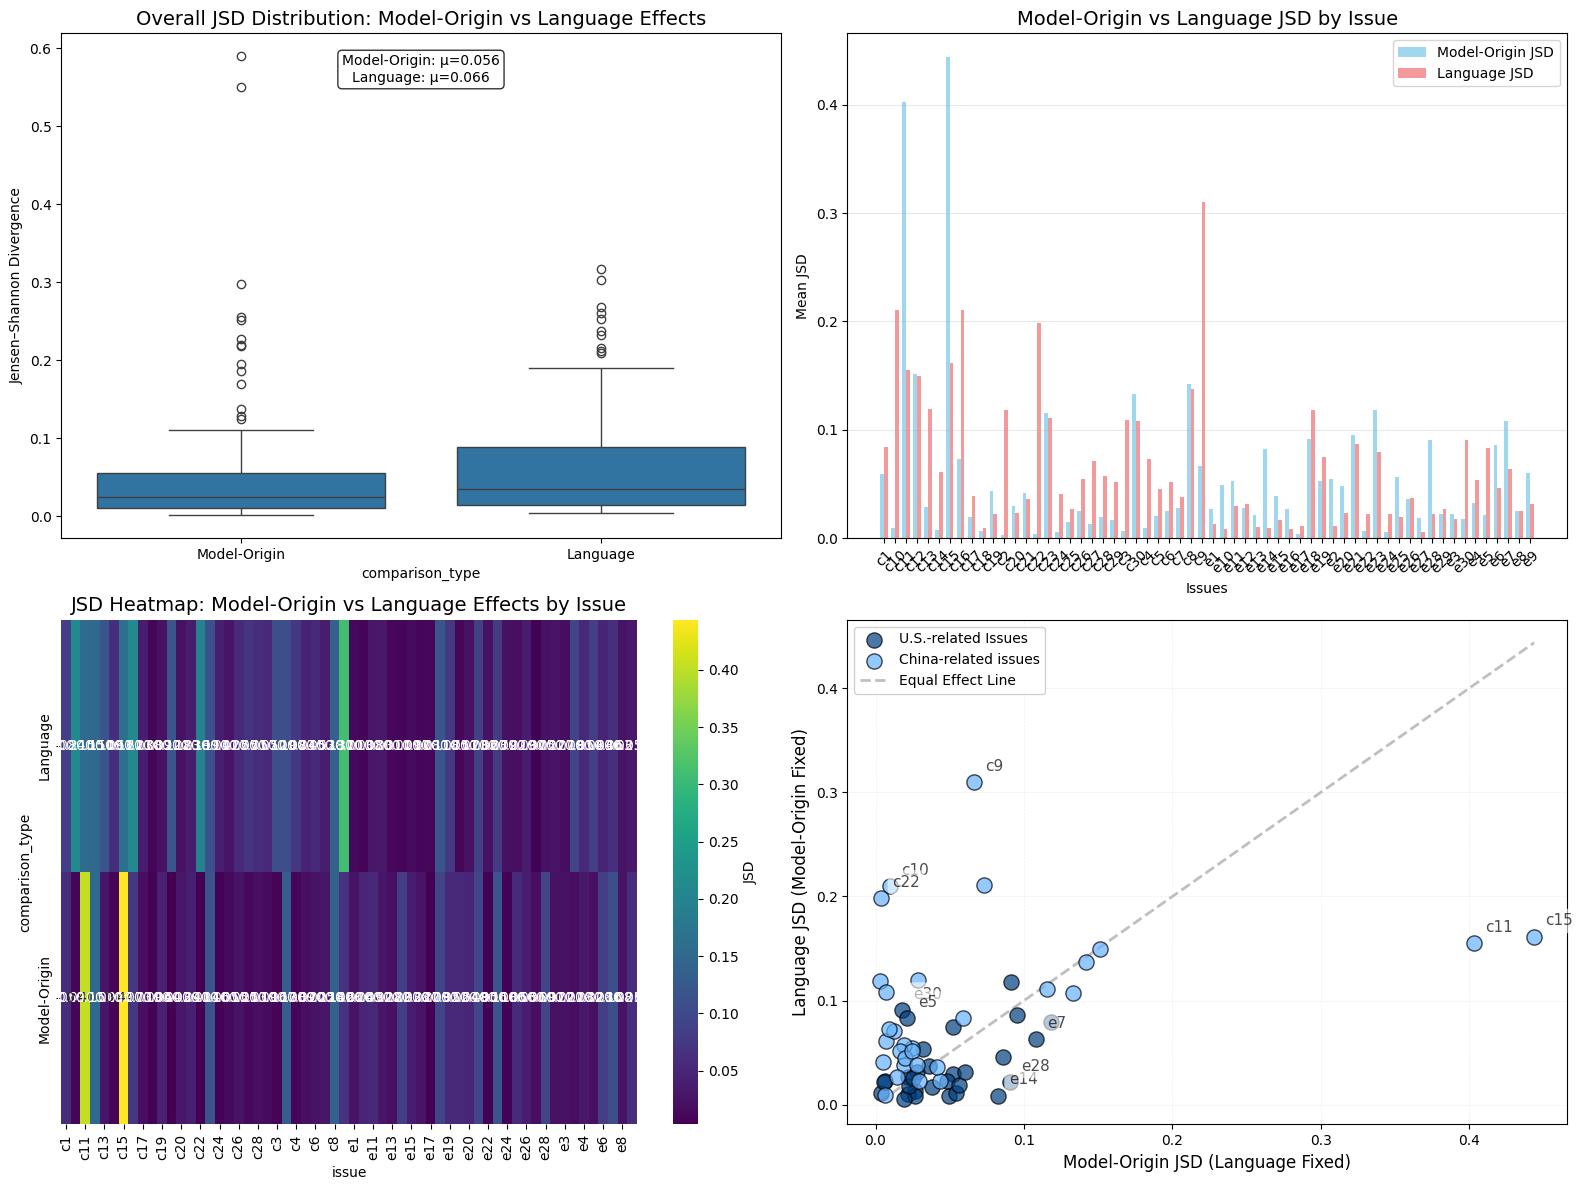


Analysis complete!
Results shape: (240, 4)


In [10]:
results = run_model_language_analysis(mapped_neutral_df, stance_col="stance")


In [11]:
map_culture = {
    "Western": ["meta-llama/llama-3.3-70b-instruct", "openai/gpt-4o-mini"],
    "Chinese": ["deepseek/deepseek-chat-v3-0324", "qwen/qwen3-235b-a22b"],
}
results_table = run_comprehensive_analysis_cross_origin(mapped_neutral_df, map_culture, stance_col="stance")
# print("- Significance indicators: *** p<0.001, ** p<0.01, * p<0.05, . p<0.10")


STARTING COMPREHENSIVE PER-ISSUE ANALYSIS (CROSS-ORIGIN ONLY)
Filtered 0 rows with missing values
Analyzing 48000 complete responses

Dataset summary:
  60 issues
  2 languages
  Western models: ['meta-llama/llama-3.3-70b-instruct', 'openai/gpt-4o-mini']
  Chinese models: ['deepseek/deepseek-chat-v3-0324', 'qwen/qwen3-235b-a22b']
Computing per-issue effects analysis (CROSS-ORIGIN ONLY)...
Western models: ['meta-llama/llama-3.3-70b-instruct', 'openai/gpt-4o-mini']
Chinese models: ['deepseek/deepseek-chat-v3-0324', 'qwen/qwen3-235b-a22b']
Processing issue 1/60: c12
Using Mann–Whitney U test
Processing issue 2/60: c17
Using Mann–Whitney U test
Processing issue 3/60: c18
Using Mann–Whitney U test
Processing issue 4/60: c30
Using Mann–Whitney U test
Processing issue 5/60: c19
Using Mann–Whitney U test
Processing issue 6/60: e7
Using Mann–Whitney U test
Processing issue 7/60: e8
Using Mann–Whitney U test
Processing issue 8/60: e28
Using Mann–Whitney U test
Processing issue 9/60: e1
Using Man

In [12]:
results_table.to_latex()

'\\begin{tabular}{llrrrrrrrrllrrlrrrlr}\n\\toprule\n & new_id & n_responses & n_model_jsds & n_language_jsds & model_mean_jsd & language_mean_jsd & jsd_difference & jsd_test_statistic & jsd_p_value & jsd_significance & jsd_effect_direction & model_cramers_v & model_cramers_p_value & model_cramers_sig & model_chi2_valid & language_cramers_v & language_cramers_p_value & language_cramers_sig & language_chi2_valid \\\\\n\\midrule\n0 & c12 & 800 & 8 & 4 & 0.192900 & 0.184800 & 0.008200 & 16.000000 & 1.000000 & ns & No difference & 0.457800 & 0.000000 & *** & True & 0.457800 & 0.000000 & *** & True \\\\\n1 & c17 & 800 & 8 & 4 & 0.044600 & 0.047600 & -0.003000 & 15.000000 & 0.933300 & ns & No difference & 0.230100 & 0.000000 & *** & False & 0.230100 & 0.000000 & *** & False \\\\\n2 & c18 & 800 & 8 & 4 & 0.021500 & 0.014900 & 0.006600 & 21.000000 & 0.460600 & ns & No difference & 0.096300 & 0.029500 & * & False & 0.096300 & 0.029500 & * & False \\\\\n3 & c30 & 800 & 8 & 4 & 0.155000 & 0.129300